In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
import random
import torch
import pdb

In [130]:
import torch
print(torch.version.cuda)

# Select GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

11.1
cuda


In [70]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
def runTraining(epoch_num, weights_path='', augm = False):
    print('-' * 40)
    print('~~~~~~~~  Starting the training... ~~~~~~')
    print('-' * 40)

    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 16
    batch_size_val = 16
    lr = 0.001   # Learning Rate
    epoch = epoch_num # Number of epochs
    
    root_dir = './Data/'

    print(' Dataset: {} '.format(root_dir))

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                      root_dir,
                                                      transform=transform,
                                                      mask_transform=mask_transform,
                                                      augment=augm,  # Set to True to enable data augmentation
                                                      equalize=False)

    train_loader_full = DataLoader(train_set_full,
                              batch_size=batch_size,
                              worker_init_fn=np.random.seed(0),
                              num_workers=0,
                              shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    equalize=False)

    val_loader = DataLoader(val_set,
                            batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = 'Test_Model'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = UNet(num_classes)
    net = net.to(device)  # Move the model to the device

    ## Load the weights from the previously trained model
    if weights_path != '':
        # previous_model_dir = './models/' + 'Test_Model' + '/' + str(epoch_num) +'_Epoch'
        net.load_state_dict(torch.load(weights_path))
        print(" Model loaded: {}".format(weights_path))

    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()

    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    ### To save statistics ####
    lossTotalTraining = []
    Best_loss_val = 1000
    BestEpoch = 0
    
    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING
    
    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train()
        lossEpoch = []
        DSCEpoch = []
        DSCEpoch_w = []
        num_batches = len(train_loader_full)
        
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data            

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)

            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = net(images)

            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            
            # COMPUTE THE LOSS
            CE_loss_value = CE_loss(softMax(net_predictions), segmentation_classes) # XXXXXX and YYYYYYY are your inputs for the CE
            lossTotal = CE_loss_value

            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            lossTotal.backward()
            optimizer.step()

            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(lossTotal.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                             prefix="[Training] Epoch: {} ".format(i),
                             length=15,
                             suffix=" Loss: {:.4f}, ".format(lossTotal))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()

        lossTotalTraining.append(lossEpoch)

        printProgressBar(num_batches, num_batches,
                             done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch) + '\n' 
                             + "[Validation] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))

        
        ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        if not os.path.exists('./models/' + modelName):
                os.makedirs('./models/' + modelName)

        torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
            
        np.save(os.path.join(directory, 'Losses.npy'), lossTotalTraining)


In [ ]:
runTraining(10000)

In [ ]:
# Run a training loop
# Looping from 9998 to 9994
for i in range(9998, 9994, -1):
    print("Epoch: {}".format(i))
    runTraining(i)


In [223]:
# Testing the model on an Image

from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

def plotOutput(model_path, image_path):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ## CREATION OF YOUR MODEL
    net_test = UNet(4)
    net_test = net_test.to(device)
    net_test.load_state_dict(torch.load(model_path))

    # Load the image
    image = Image.open(image_path)

    # Convert the image to grayscale
    if image.mode != 'L':
        image = image.convert('L')

    # Preprocess the image
    x = TF.to_tensor(image)
    x = TF.normalize(x, [0.5], [0.5])
    x = x.unsqueeze(0)  # Add batch dimension

    # Move the tensor to the same device as the model
    x = x.to(device)

    output = net_test(x)

    # The output is the predicted segmentation
    predicted_segmentation = torch.argmax(output.squeeze(), dim=0)

    # Convert the tensor to a numpy array
    predicted_segmentation = predicted_segmentation.detach().cpu().numpy()

    # Display the predicted segmentation
    plt.imshow(predicted_segmentation, cmap='gray')
    plt.show()

In [207]:
# Output the training and validation loss of given weights

def getLoss(weights_path):
    # Load the weights from the file
    model = UNet(4)
    model.load_state_dict(torch.load(weights_path))

    # Determine the device and move the model to the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()

    # Set the model to evaluation mode
    model.eval()

    # Initialize the loss function
    CE_loss = torch.nn.CrossEntropyLoss()

    # Initialize a variable to store the total loss
    root_dir = './Data/'

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                        root_dir,
                                                        transform=transform,
                                                        mask_transform=mask_transform,
                                                        augment=True,  # Set to True to enable data augmentation
                                                        equalize=False)

    train_loader_full = DataLoader(train_set_full,
                                batch_size=16,
                                worker_init_fn=np.random.seed(0),
                                num_workers=0,
                                shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    equalize=False)

    val_loader = DataLoader(val_set,                 
                            batch_size=16,       
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)

    lossEpoch_train = []
    lossEpoch_val = []


    for j, data in enumerate(train_loader_full):
        ### Set to zero all the gradients
        model.zero_grad()

        ## GET IMAGES, LABELS and IMG NAMES
        images, labels, img_names = data            

        ### From numpy to torch variables
        labels = to_var(labels)
        images = to_var(images)

        ################### Train ###################
        #-- The CNN makes its predictions (forward pass)
        net_predictions = model(images)

        #-- Compute the losses --#
        # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
        segmentation_classes = getTargetSegmentation(labels)
        
        # COMPUTE THE LOSS
        CE_loss_value = CE_loss(softMax(net_predictions), segmentation_classes) # XXXXXX and YYYYYYY are your inputs for the CE
        
        lossTotal = CE_loss_value
        lossEpoch_train.append(lossTotal.item())

    lossEpoch_train = np.asarray(lossEpoch_train)
    lossEpoch_train = lossEpoch_train.mean()


    for j, data in enumerate(val_loader):
        ## GET IMAGES, LABELS and IMG NAMES
        images, labels, img_names = data            

        ### From numpy to torch variables
        labels = to_var(labels)
        images = to_var(images)

        ################### Validate ###################
        #-- The CNN makes its predictions (forward pass)
        net_predictions = model(images)

        #-- Compute the losses --#
        # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
        segmentation_classes = getTargetSegmentation(labels)
        
        # COMPUTE THE LOSS
        CE_loss_value = CE_loss(softMax(net_predictions), segmentation_classes) # XXXXXX and YYYYYYY are your inputs for the CE
        
        lossTotal = CE_loss_value
        lossEpoch_val.append(lossTotal.item())

    lossEpoch_val = np.asarray(lossEpoch_val)
    lossEpoch_val = lossEpoch_val.mean()

    print('Training loss:', lossEpoch_train)
    print('Validation loss:', lossEpoch_val)
    return lossEpoch_train, lossEpoch_val

Training loss: 0.7740990152725806
Validation loss: 0.7728778839111328
Training loss: 0.7640887453005865
Validation loss: 0.7592176079750061
Training loss: 0.763226201901069
Validation loss: 0.7597171068191528
Training loss: 0.7632174858680139
Validation loss: 0.7588107228279114
Training loss: 0.7635183563599219
Validation loss: 0.7601764798164368
Training loss: 0.7637501313136175
Validation loss: 0.7587930679321289
Training loss: 0.7649361537053034
Validation loss: 0.7601703643798828
Training loss: 0.7643723900501544
Validation loss: 0.7607229232788086
Training loss: 0.76371136536965
Validation loss: 0.7611664056777954
Training loss: 0.7623245991193331
Validation loss: 0.7600800514221191
Training loss: 0.7469649819227365
Validation loss: 0.7533664107322693
Training loss: 0.7467905099575336
Validation loss: 0.7535131216049195
Training loss: 0.7465937504401574
Validation loss: 0.753258204460144
Training loss: 0.7467561960220337
Validation loss: 0.75386061668396
Training loss: 0.746575589

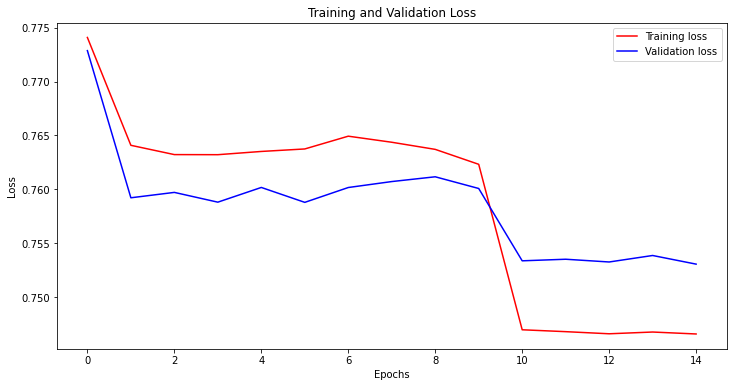

In [238]:
# Plotting the training and validation loss for multiple models
import matplotlib.pyplot as plt

# models_paths = ['./models/' + 'Trained' + '/Adam_Labeled_1.3k_Epoch']
# models_paths = ['./models/' + 'Trained\Data_Augmented' + '/Adam_Labeled_' + str(i) + '5k_Epoch' for i in range(0, 8)]
models_paths = ['./models/' + 'Test_Model' + '/' + str(i) + '0_Epoch' for i in range(10,1500,100)]
# List to store the losses
train_losses = []
val_losses = []

# Iterate over the list of paths
for path in models_paths:
    # Get the losses for the current path
    train_loss, val_loss = getLoss(path)
    
    # Add the losses to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the losses
epochs = range(len(train_losses))
# epochs = [(5 + 10*i)*1000 for i in range(len(train_losses))]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

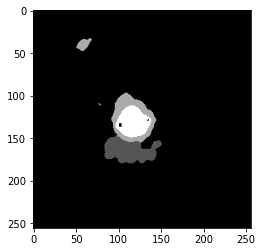

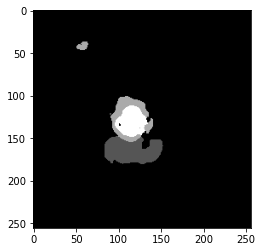

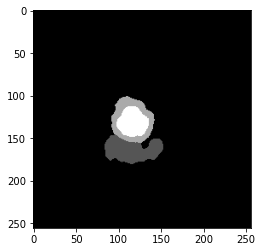

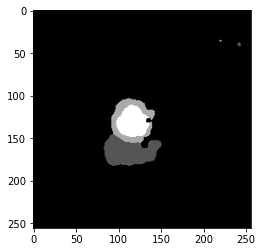

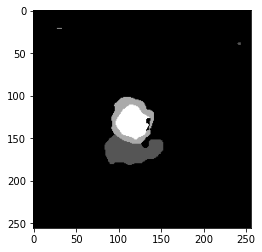

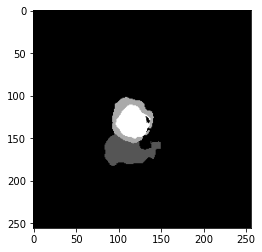

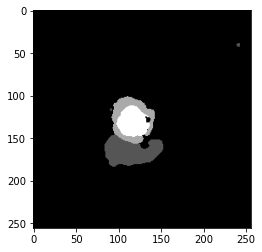

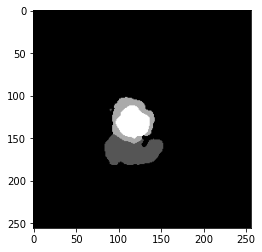

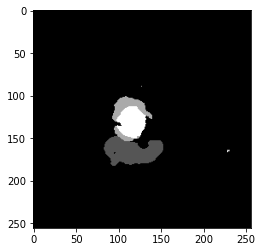

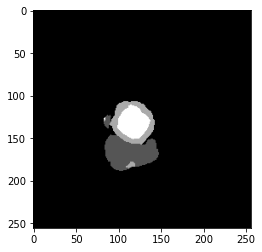

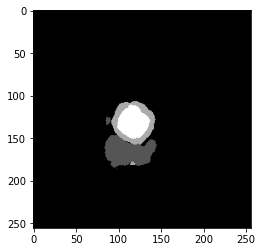

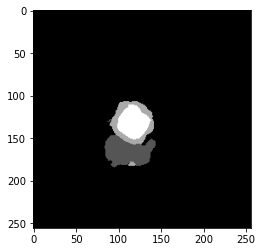

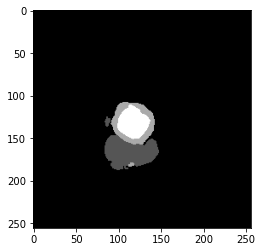

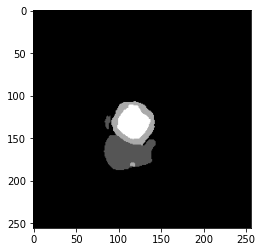

In [237]:
# Displaying the outputs for different models

models_paths = ['./models/' + 'Test_Model' + '/' + str(i) + '999_Epoch' for i in range(1,15)]
# models_paths = ['./models/' + 'Trained/Data_Augmented_15K_EpochPlus' + '/Adam_Labeled_' + str(i) + '5k_Epoch' for i in range(0, 8)]
image_path = "./Data/val/Img/patient061_01_1.png"

for model_path in models_paths:
    plotOutput(model_path, image_path)